## Imports and Helper Functions

In [15]:
import pandas as pd
import mplleaflet
import mapclassify
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import numpy as np

# Replace any number of spaces with just a single space
def refineSpaces(x):
    return x.replace('\s+', ' ', regex=True)

# Remove leading and trailing white space
def removeExcessWhitespace(x):
    return x.str.strip()

# Convert the string to uppercase
def toUpper(x):
    return x.str.upper()


## Define what data you want

In [34]:
censusDataPath = 'data/csv/census/nyc-median-income-2017.csv' # shouldnt change the year since this is a 5 year estimate
censusDataColumn = 'Median income (dollars); Estimate; Households'

violationDataPath = 'data/csv/ParkingViolations/nyc-parking-violations-partial-2016.csv'

legendTitle = 'Median Income, Thousands of USD'
mapTitle = 'NYC Median Income vs Parking Violations - 2016'

imageName = 'generated/median-income-2016.png'
htmlName = 'generated/median-income-2016.html'


## Data Cleaning

In [35]:
violations = pd.read_csv(violationDataPath)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(refineSpaces)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(removeExcessWhitespace)
violations[['House Number', 'Street Name']] = violations[['House Number', 'Street Name']].apply(toUpper)

openmaps = pd.read_csv('data/csv/nyc-address-to-zip-code.csv')
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(refineSpaces)
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(removeExcessWhitespace)
openmaps[['NUMBER', 'STREET']] = openmaps[['NUMBER', 'STREET']].apply(toUpper)

# read in shape data and turn zcta(zip code) into an int
shapes = gpd.read_file('data/shp/nyc-shape-by-zip')
shapes['zcta'] = shapes['zcta'].astype(int)

# read in census data and ensure that row has numeric data
censusData = pd.read_csv(censusDataPath)
censusData = censusData[pd.to_numeric(censusData[censusDataColumn], errors='coerce').notnull()]

print("Done cleaning data.")


Done cleaning data.


# Merge based on address

In [36]:
# merge in zip code based on address
merged = pd.merge(violations, openmaps,  how='inner', left_on=['House Number','Street Name'], right_on = ['NUMBER','STREET'])
print(merged.shape)

# merge in shapefile stuff on zip code
merged = pd.merge(merged, shapes, how='inner', left_on=['POSTCODE'], right_on=['zcta'])

# merge in mean income data based on zip code
merged = pd.merge(merged, censusData[['Id2', censusDataColumn]], how='inner', left_on=['POSTCODE'], right_on=['Id2'])

merged.to_csv("generated/nyc-merged-data-all.csv")

print("Done merging data frames.")


(24656, 55)
Done merging data frames.


## Plot violations and shape data

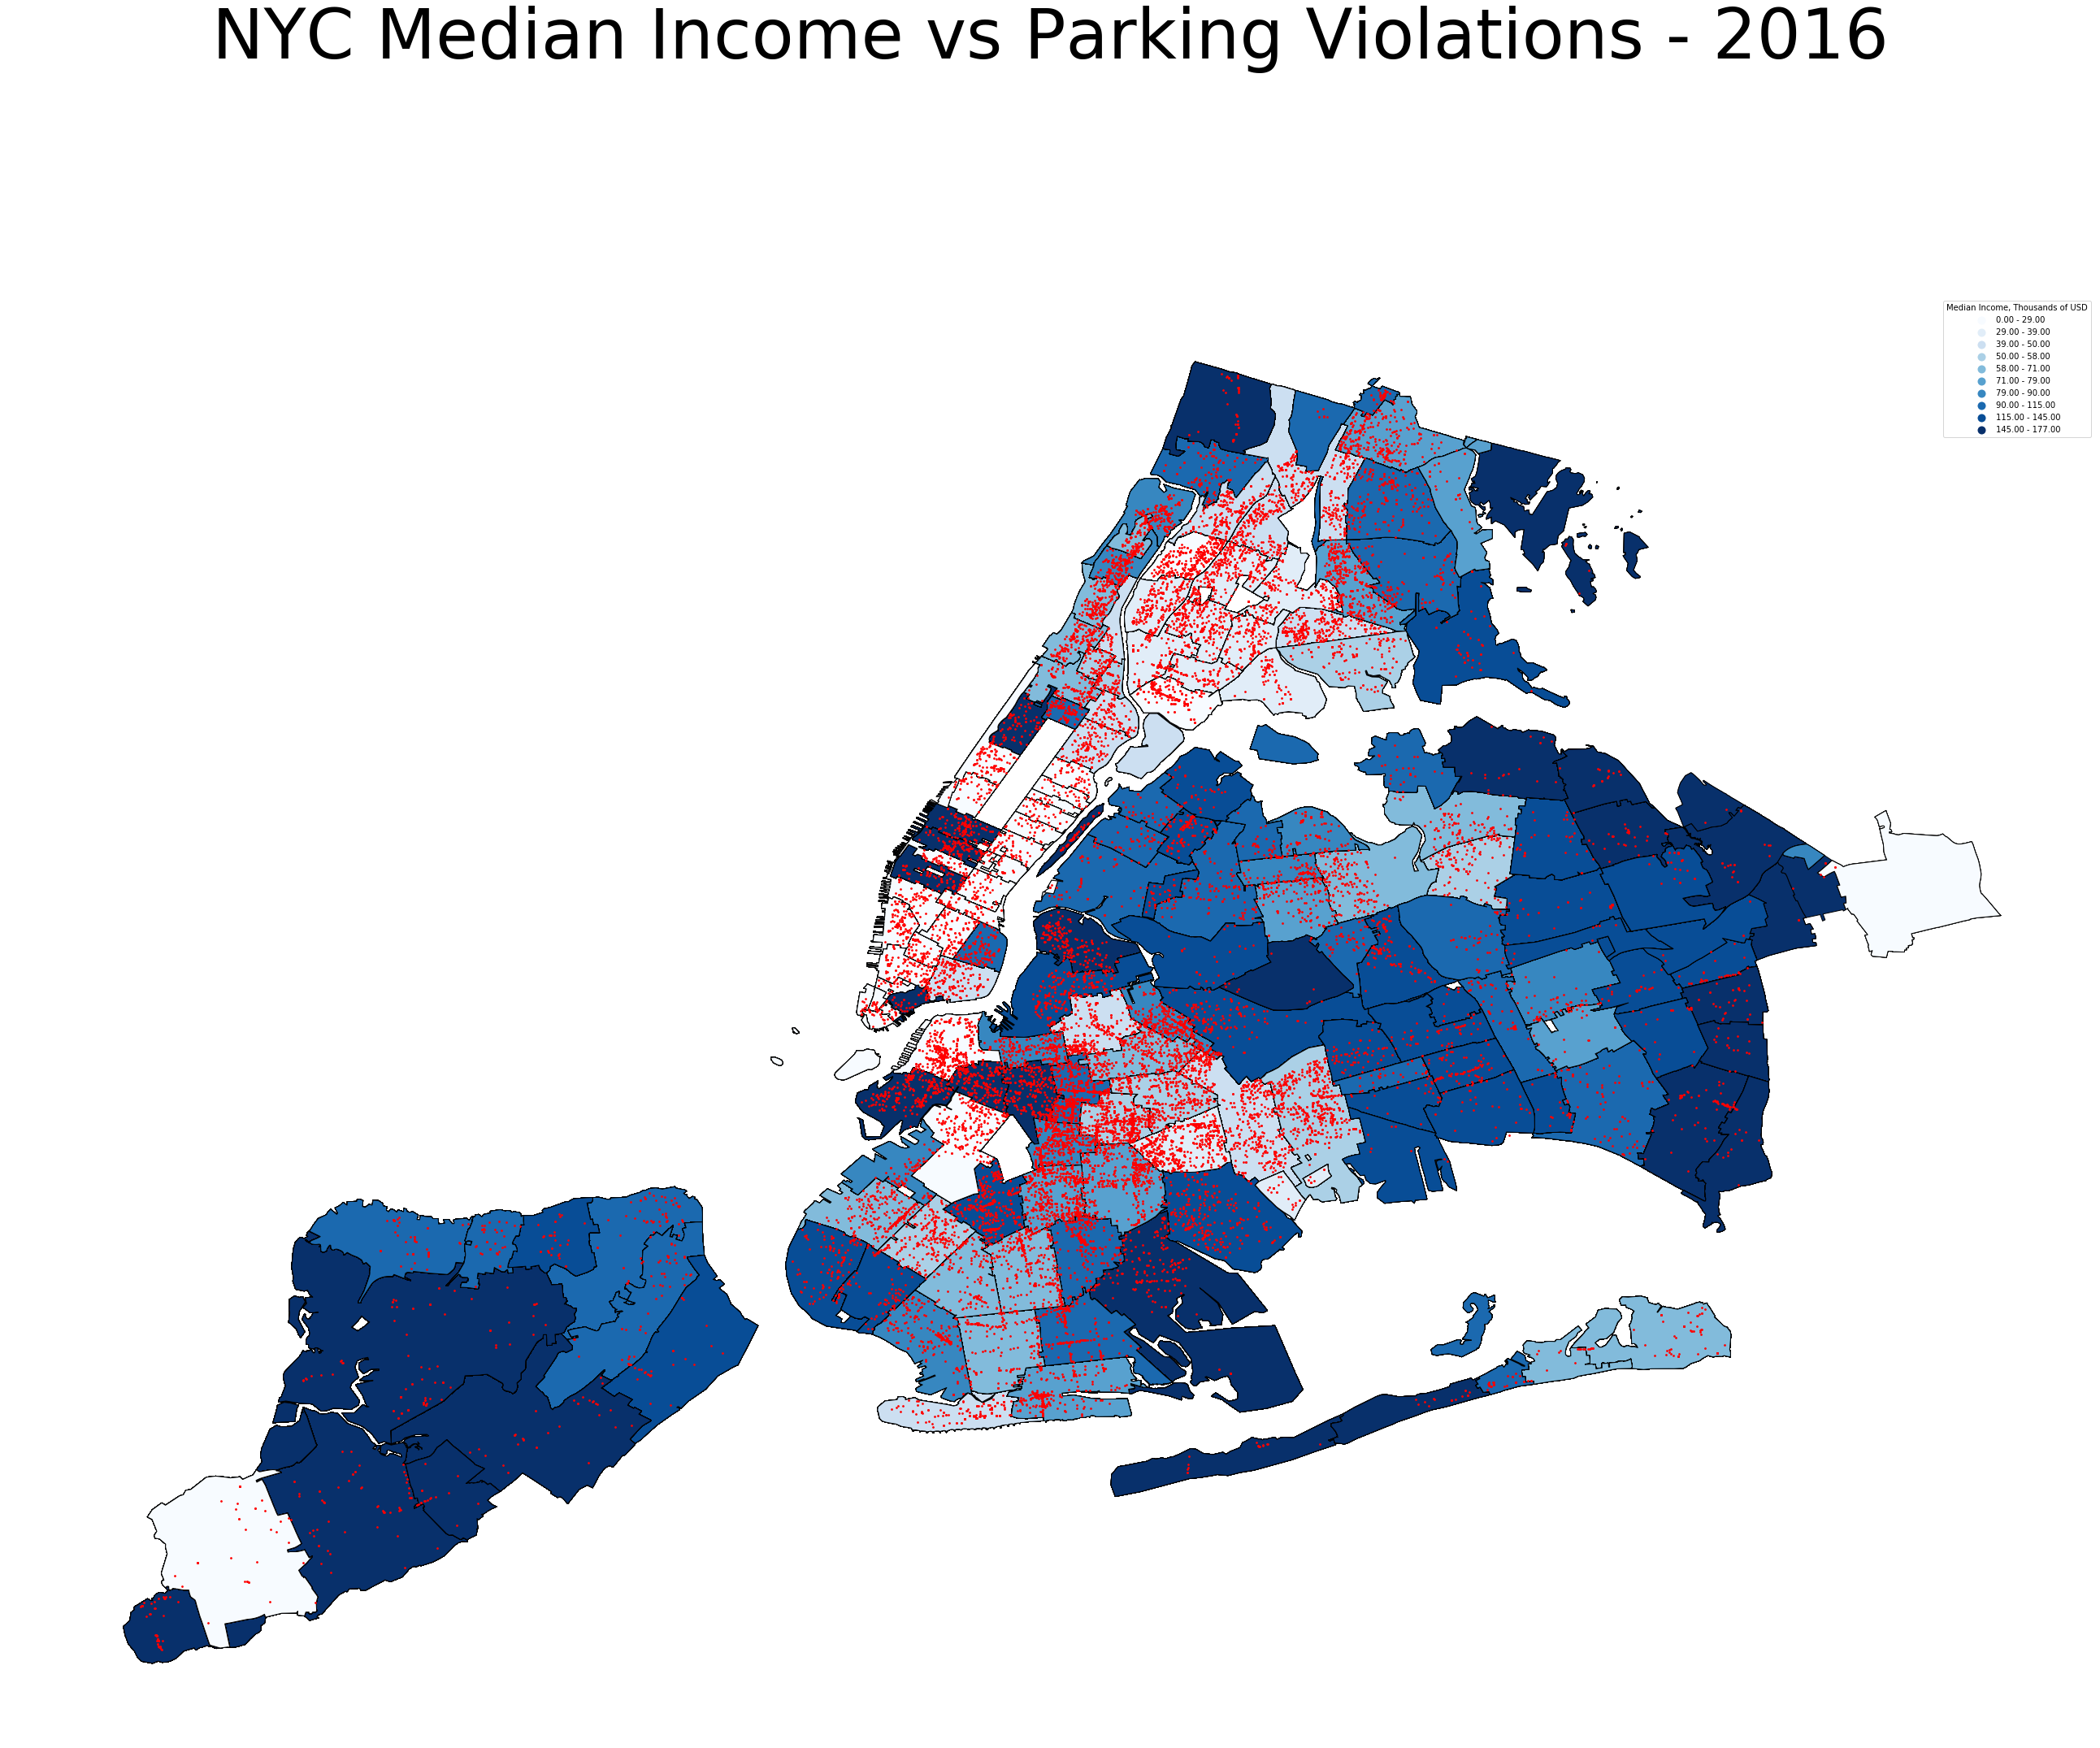

In [37]:
# legend cannot be shown to mplleaflet. comment out the first one if youre plotting to mflleaflet
ax = GeoDataFrame(merged).plot(column=censusDataColumn,  cmap='Blues', scheme='QUANTILES', k=10, figsize=(36, 36), edgecolor='black', legend=True, legend_kwds={'title': legendTitle})
#ax = GeoDataFrame(merged).plot(column=censusDataColumn,  cmap='Blues', scheme='QUANTILES', k=10, figsize=(36, 36), edgecolor='black')

ax = plt.scatter(merged['LON'], merged['LAT'], marker='o', s=3, color="red")

plt.axis('off')

figure = ax.figure
figure.suptitle(mapTitle, fontsize=85)
figure.tight_layout()
figure.subplots_adjust(top=1.0)

figure.savefig(imageName, dpi=300)
plt.show()
#mplleaflet.save_html(fig=figure, fileobj=htmlName)
